In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("Housing_dataset_train.csv")
test = pd.read_csv("Housing_dataset_test.csv")
sub = pd.read_csv("Sample_submission.csv")
#var = pd.read_csv("VariableDefinitions.csv")

In [3]:
train

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898
...,...,...,...,...,...,...,...
13995,6175,Edo,Bungalow,NaN,7.0,NaN,2367927.861
13996,9704,Kaduna,Apartment,NaN,7.0,5.0,2228516.471
13997,11190,Plateau,Bungalow,8.0,6.0,5.0,2406812.693
13998,9256,Delta,Flat,NaN,6.0,1.0,3348918.718


In [4]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


#### How many values are missing in each column?

From the plot below, we can see that the location represented as "loc" has the most missing data

In [5]:
data = train.drop(["price"], axis=1).append(test)
data = data.drop("ID", axis=1)
data.isnull().sum()

loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
dtype: int64

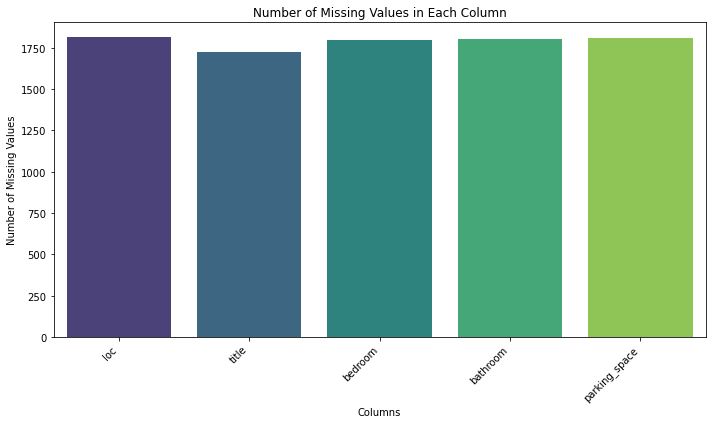

In [6]:
# Calculate the number of missing values in each column
missing_values_count = data.isnull().sum()

# Create a colorful bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values_count.index, y=missing_values_count.values, palette='viridis')

# Set plot properties
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


#### Exploring the data

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Check General Information
print(data.info())

# Step 2: Summary Statistics
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            18187 non-null  object 
 1   title          18278 non-null  object 
 2   bedroom        18201 non-null  float64
 3   bathroom       18195 non-null  float64
 4   parking_space  18189 non-null  float64
dtypes: float64(3), object(2)
memory usage: 937.5+ KB
None
            bedroom      bathroom  parking_space
count  18201.000000  18195.000000   18189.000000
mean       4.315312      3.124815       3.157458
std        2.445600      2.035028       1.601164
min        1.000000      1.000000       1.000000
25%        2.000000      1.000000       2.000000
50%        4.000000      2.000000       3.000000
75%        6.000000      5.000000       4.000000
max        9.000000      7.000000       6.000000


#### Distribution of bedrooms in the whole dataset

We observe that houses with 5 bedrooms have the most occurence

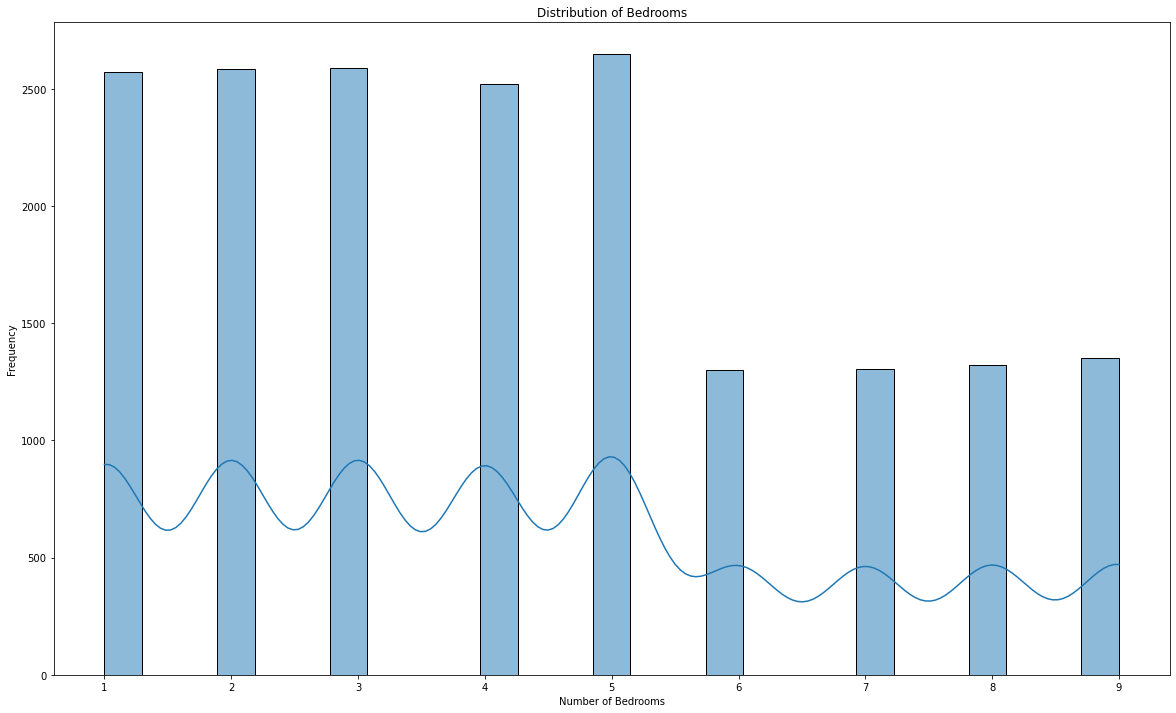

In [8]:
plt.figure(figsize=(20, 12));

# Step 3: Distribution Plots
sns.histplot(data['bedroom'], kde=True)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')
plt.title('Distribution of Bedrooms')
plt.show()


#### Distribution of Bathrooms in the whole dataset

We Observe that most houses in the dataset have only one bathroom.

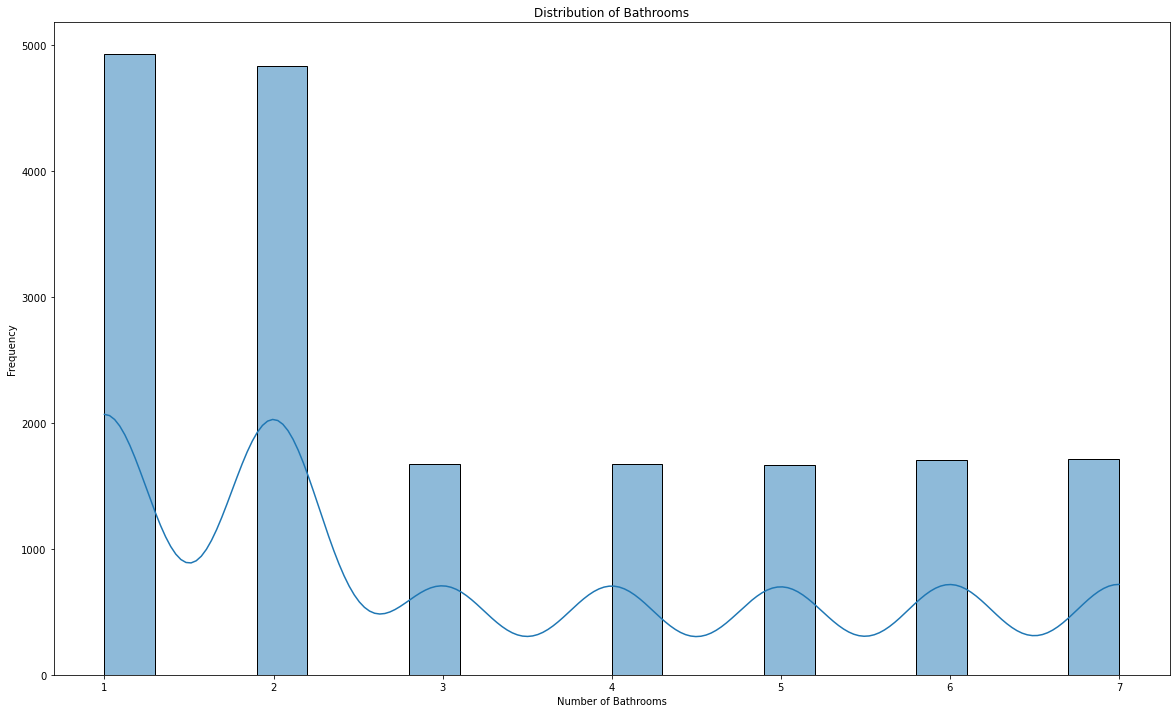

In [9]:
plt.figure(figsize=(20, 12));
sns.histplot(data['bathroom'], kde=True)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Frequency')
plt.title('Distribution of Bathrooms')
plt.show()

#### Distribution of Parking Spaces.

Most houses in the dataset have just 2 parking spaces

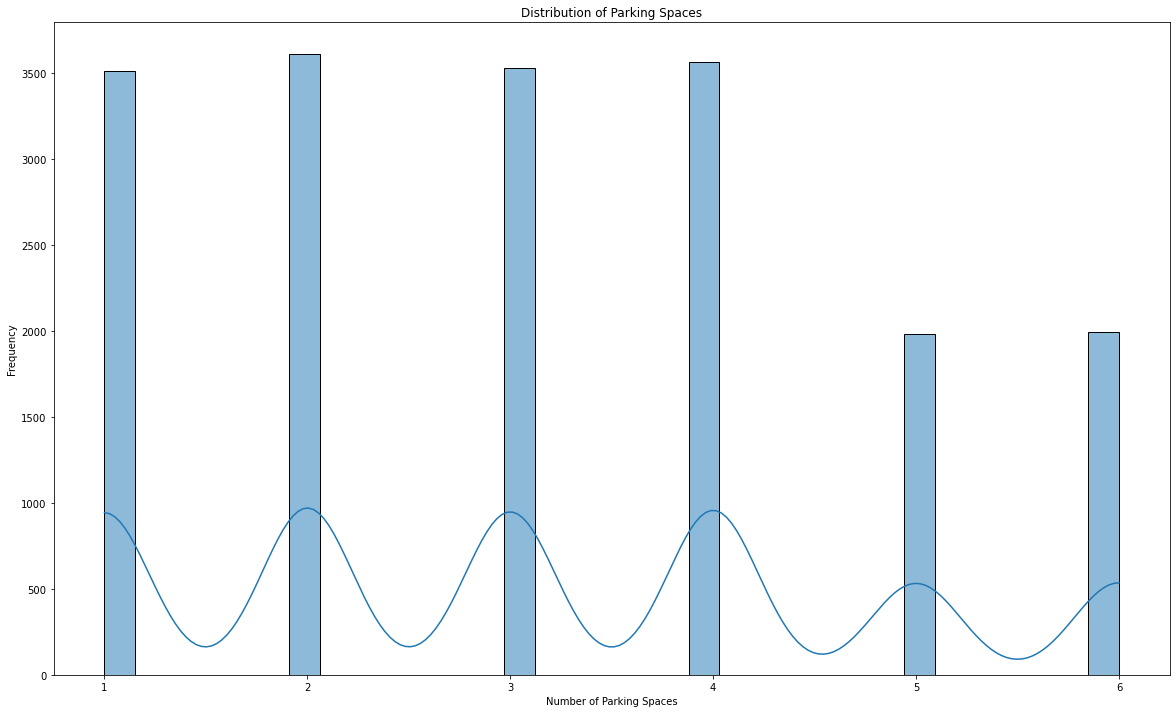

In [10]:
plt.figure(figsize=(20, 12));

sns.histplot(data['parking_space'], kde=True)
plt.xlabel('Number of Parking Spaces')
plt.ylabel('Frequency')
plt.title('Distribution of Parking Spaces')
plt.show()

#### Distribution of Location

The Distribution of location in the dataset is also fair.

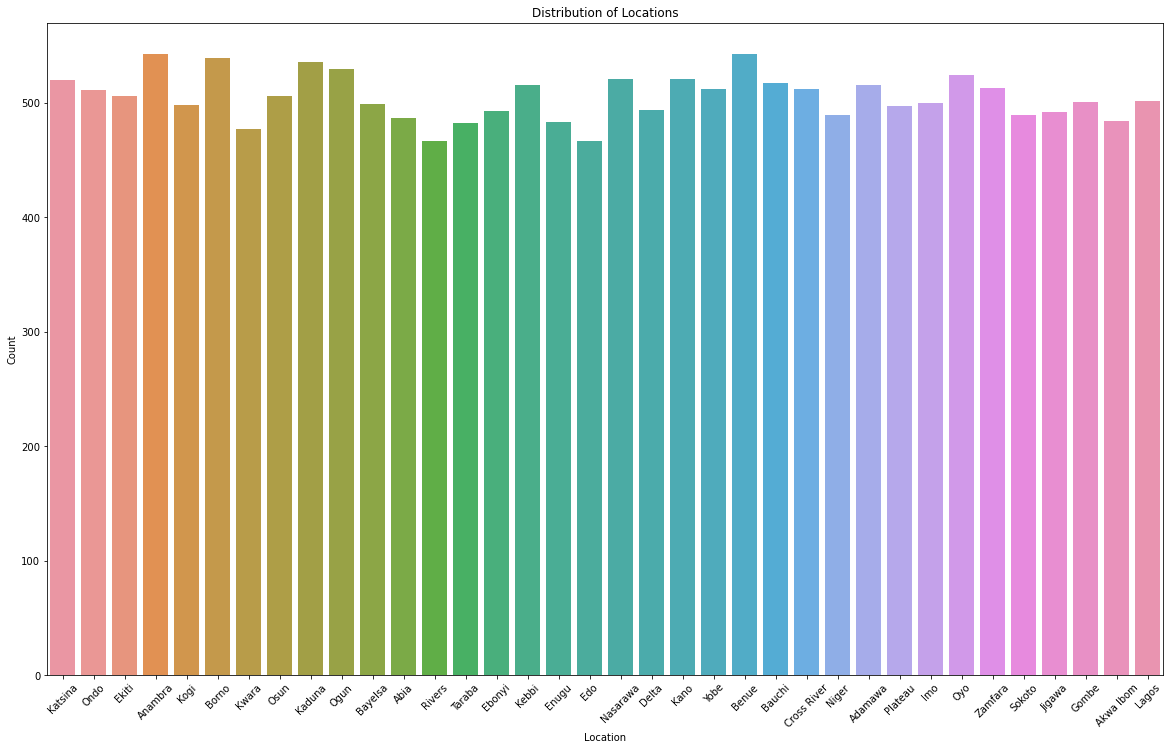

In [11]:
# Step 4: Categorical Plots
plt.figure(figsize=(20, 12));
sns.countplot(data['loc'])
plt.xticks(rotation=45)
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Distribution of Locations')
plt.show()

#### Distribution of House Types

The "cottage" house type in the dataset is quite low compared to the others

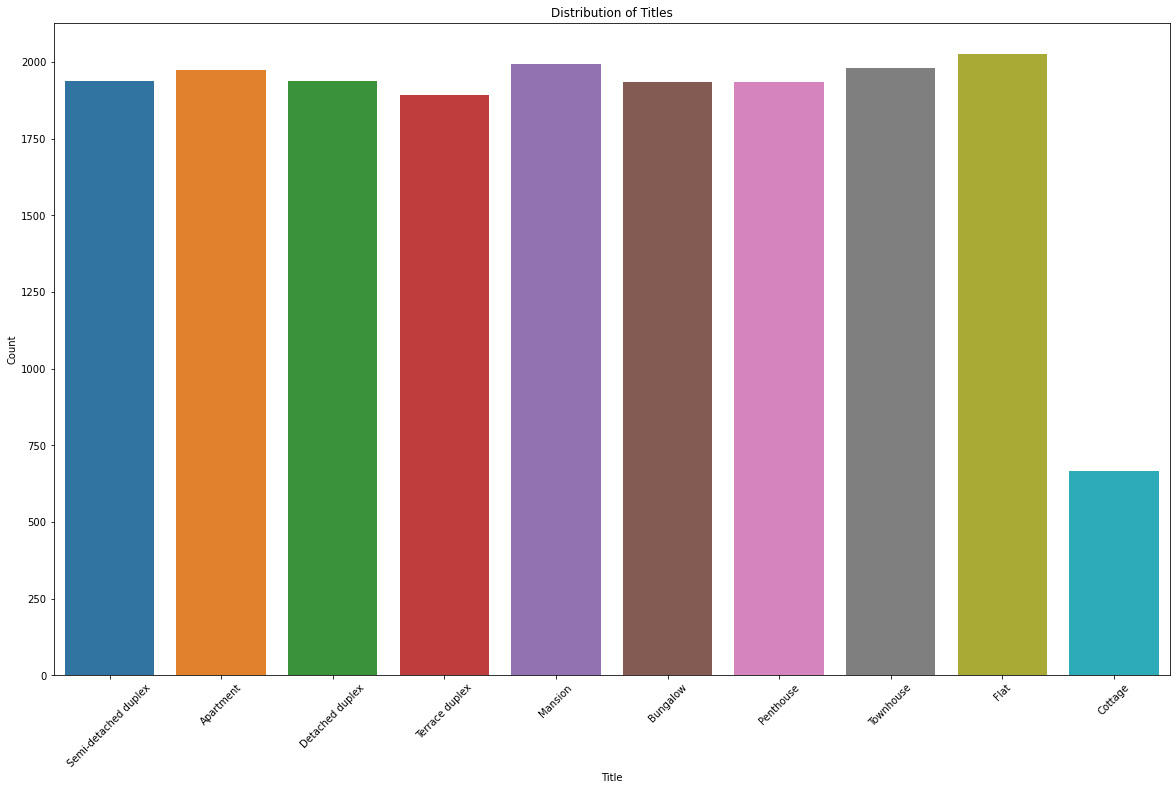

In [12]:
plt.figure(figsize=(20, 12));
sns.countplot(data['title'])
plt.xticks(rotation=45)
plt.xlabel('Title')
plt.ylabel('Count')
plt.title('Distribution of Titles')
plt.show()


#### Correlation.

The number of bedrooms and bathrooms seem to be the most correlated of the numerical features

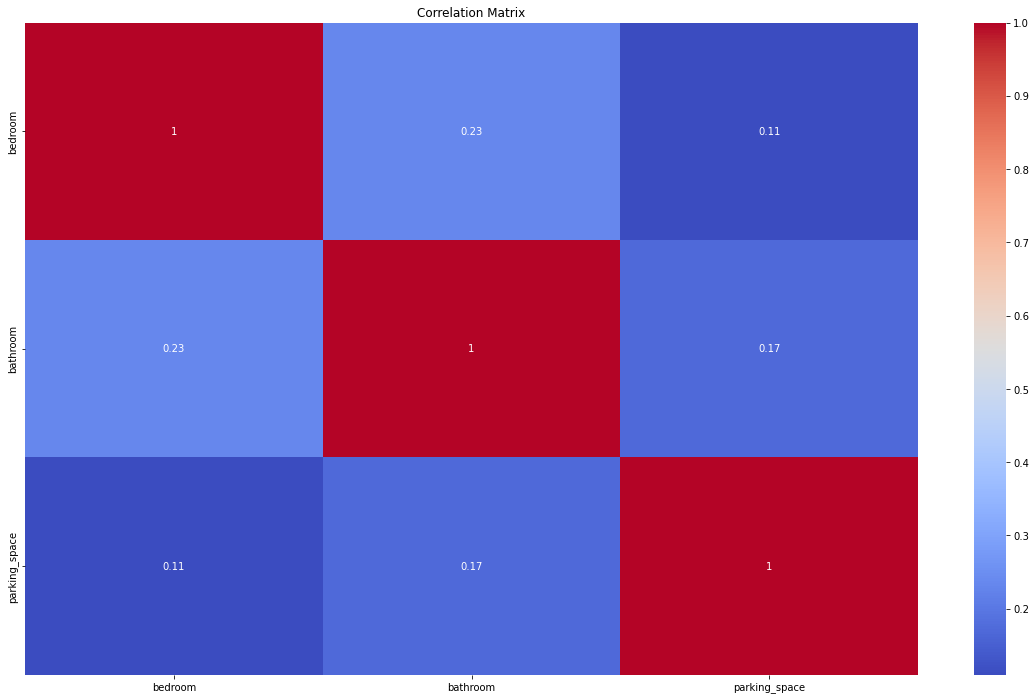

In [13]:
# Step 5: Correlation Analysis (if applicable)
plt.figure(figsize=(20, 12));
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Price Data Exploration

##### What number of bedrooms have the highest price?

The Scatterplot shows that the houses that have the highest price have 5 bedrooms

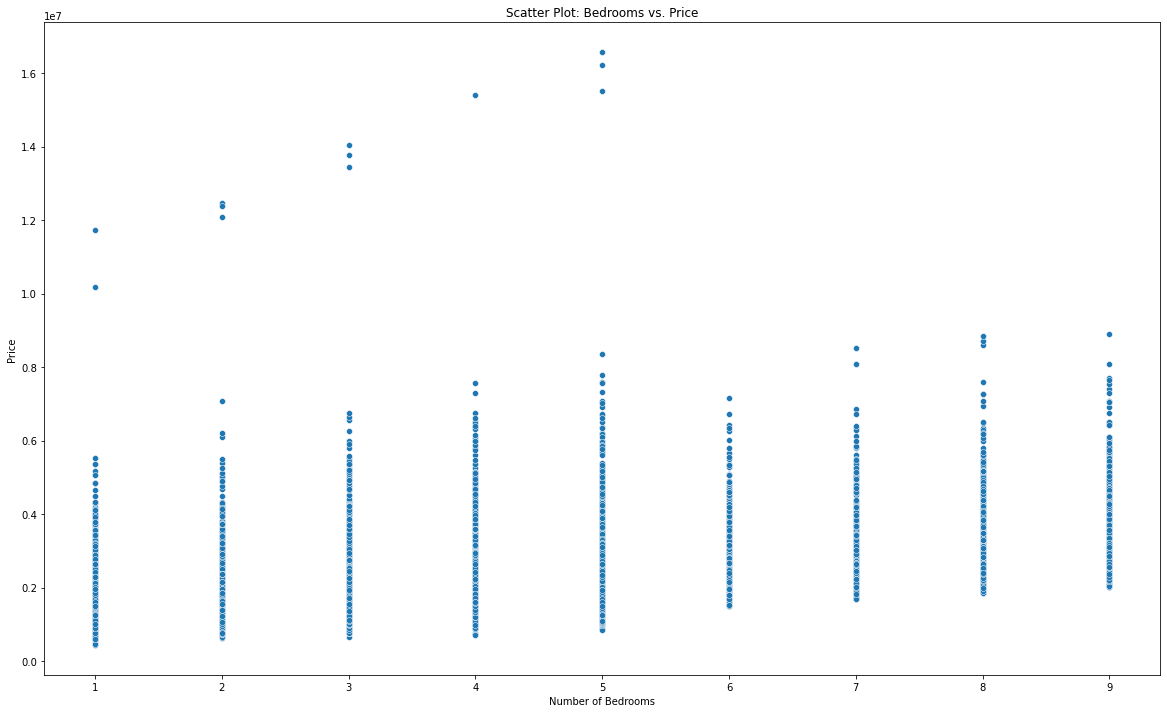

In [14]:
# Step 6: Explore Relationships with Price (Scatter Plots)
plt.figure(figsize=(20, 12));
sns.scatterplot(data=train, x='bedroom', y='price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.title('Scatter Plot: Bedrooms vs. Price')
plt.show()

##### Bedrooms by Prices.

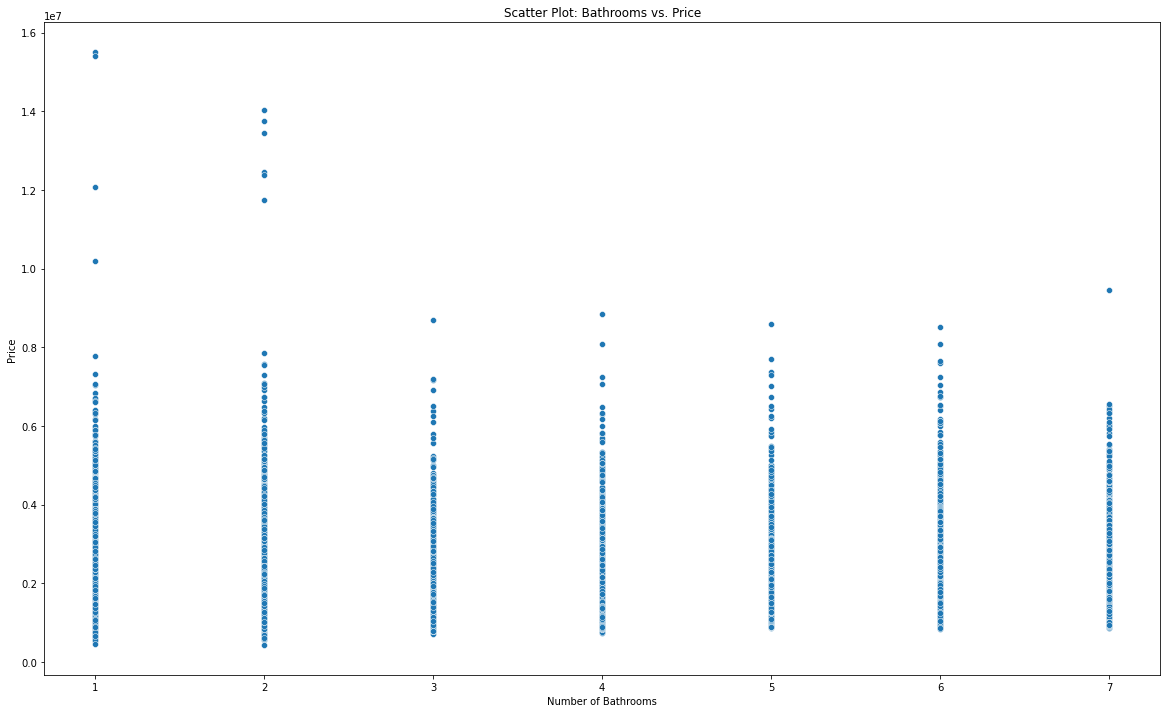

In [15]:
plt.figure(figsize=(20, 12));
sns.scatterplot(data=train, x='bathroom', y='price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')
plt.title('Scatter Plot: Bathrooms vs. Price')
plt.show()

##### Parking Spaces by Prices.

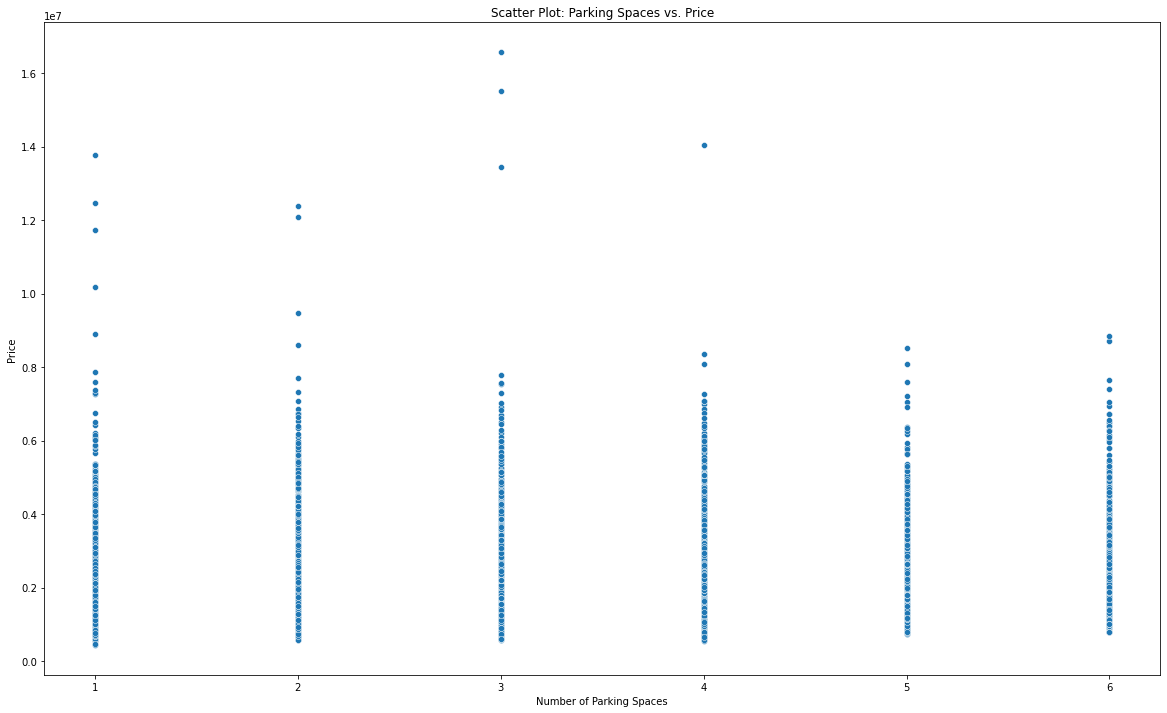

In [16]:
plt.figure(figsize=(20, 12));
sns.scatterplot(data=train, x='parking_space', y='price')
plt.xlabel('Number of Parking Spaces')
plt.ylabel('Price')
plt.title('Scatter Plot: Parking Spaces vs. Price')
plt.show()

##### Prices of Houses by Location

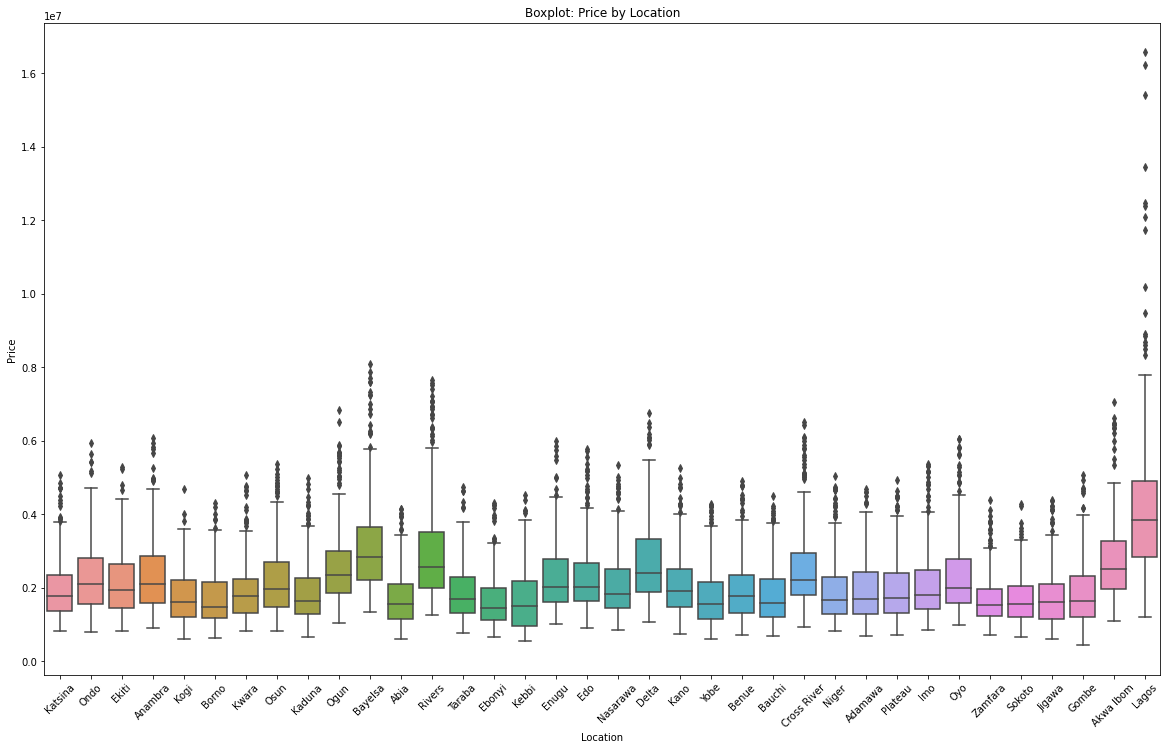

In [17]:
plt.figure(figsize=(20, 12));
sns.boxplot(data=train, x='loc', y='price')
plt.xticks(rotation=45)
plt.xlabel('Location')
plt.ylabel('Price')
plt.title('Boxplot: Price by Location')
plt.show()


##### Prices of Houses by House Type

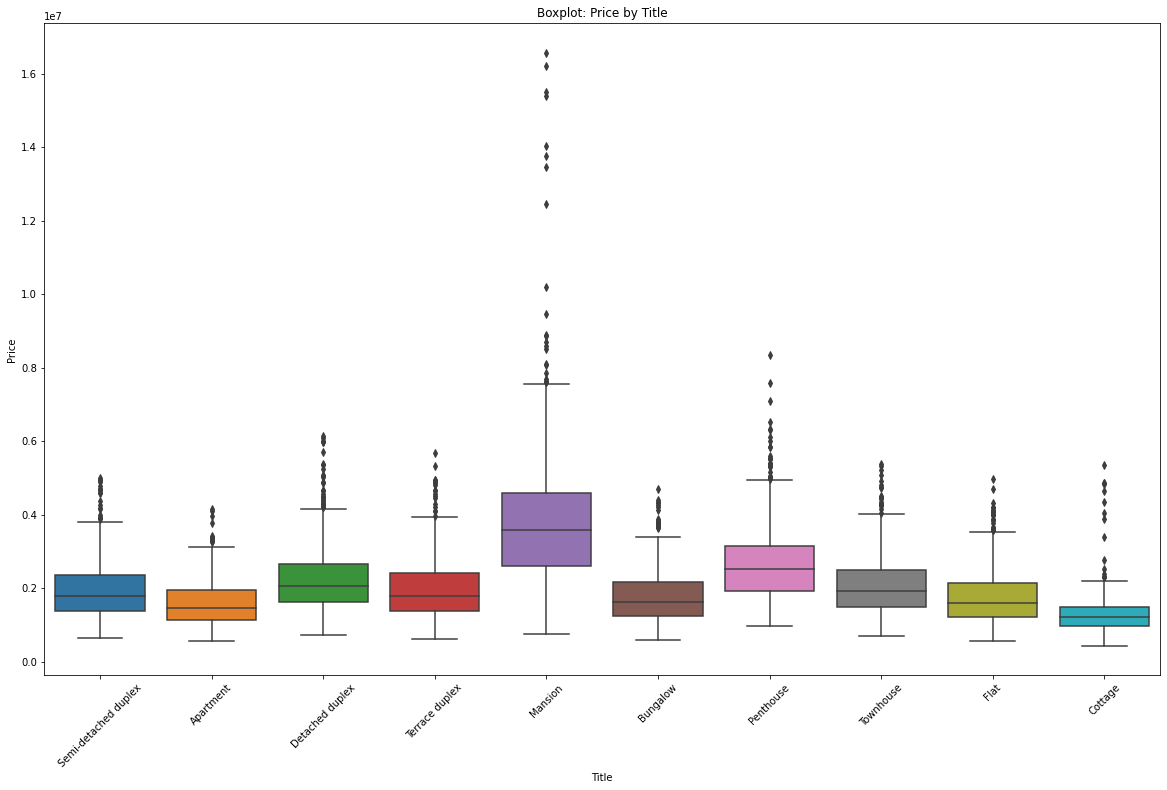

In [18]:
plt.figure(figsize=(20, 12));
sns.boxplot(data=train, x='title', y='price')
plt.xticks(rotation=45)
plt.xlabel('Title')
plt.ylabel('Price')
plt.title('Boxplot: Price by Title')
plt.show()


##### Price Disribution

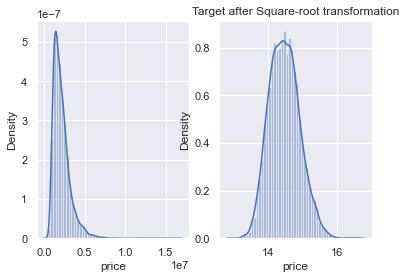

In [19]:
sns.set()
y = train.price
y_transformed = pd.Series(np.log(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Square-root transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed, ax=ax[1])
plt.show()

In [20]:
# Define the ranking based on size (arranged from smallest to biggest)
house_type_ranks = {
"Apartment":1,
"Flat":2,
"Cottage":3,
"Semi-detached duplex":4,
"Terrace duplex":5,
"Bungalow":6,
"Townhouse":7,
"Detached duplex":8,
"Penthouse":9,
"Mansion":10,
}



# Map the house types to numerical values based on size ranking
data['title'] = data['title'].map(house_type_ranks)

# Create the 'Total Rooms' feature
data['Total_Rooms'] = data['bedroom'] + data['bathroom']


# Do all rooms have bathrooms?
# Create the 'Bathroom-to-Bedroom Ratio' feature
data['Bathroom_to_Bedroom_Ratio'] = data['bathroom'] / data['bedroom']



# Define a dictionary to map states to their respective regions
state_to_region = {
    'Abia': 'South-East',
    'Adamawa': 'North-East',
    'Akwa Ibom': 'South-South',
    'Anambra': 'South-East',
    'Bauchi': 'North-East',
    'Bayelsa': 'South-South',
    'Benue': 'North-Central',
    'Borno': 'North-East',
    'Cross River': 'South-South',
    'Delta': 'South-South',
    'Ebonyi': 'South-East',
    'Edo': 'South-South',
    'Ekiti': 'South-West',
    'Enugu': 'South-East',
    'Gombe': 'North-East',
    'Imo': 'South-East',
    'Jigawa': 'North-West',
    'Kaduna': 'North-West',
    'Kano': 'North-West',
    'Katsina': 'North-West',
    'Kebbi': 'North-West',
    'Kogi': 'North-Central',
    'Kwara': 'North-Central',
    'Lagos': 'South-West',
    'Nasarawa': 'North-Central',
    'Niger': 'North-Central',
    'Ogun': 'South-West',
    'Ondo': 'South-West',
    'Osun': 'South-West',
    'Oyo': 'South-West',
    'Plateau': 'North-Central',
    'Rivers': 'South-South',
    'Sokoto': 'North-West',
    'Taraba': 'North-East',
    'Yobe': 'North-East',
    'Zamfara': 'North-West'
}

# Map the states to their respective regions
data['Region'] = data['loc'].map(state_to_region)

# One-hot encode the 'Region' column
data = pd.get_dummies(data, columns=['Region'], prefix='', prefix_sep='')


# Extract the numerical features 'latitude' and 'loc' for imputation
impute_data = data.copy()

# Calculate the frequency of each category in the 'loc' column
category_frequencies = data['loc'].value_counts(normalize=True)

# Create a dictionary to map each category to its corresponding frequency
loc_frequency_mapping = category_frequencies.to_dict()

# Map the 'loc' column to its corresponding frequency values
data['loc'] = data['loc'].map(loc_frequency_mapping)

import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# Assuming you have your dataframe 'data' and want to perform regression imputation on columns with missing values

# Create a copy of the dataframe to avoid modifying the original data
impute_data = data.copy()

# Get the columns with missing values
columns_with_missing = impute_data.columns[impute_data.isnull().any()]

# Perform regression imputation for each column with missing values
for target in columns_with_missing:
    # Select features for regression imputation (consider using other relevant features if available)
    features = impute_data.columns.difference([target])
    
    # Split the data into known (non-missing) and missing values for the target feature
    known_data = impute_data.loc[impute_data[target].notnull(), features.to_list() + [target]]
    missing_data = impute_data.loc[impute_data[target].isnull(), features.to_list()]

    # Separate the target and features for known and missing data
    X_known = known_data[features]
    y_known = known_data[target]
    X_missing = missing_data[features]

    # Create a regression model
    regression_model = LGBMRegressor()

    # Fit the regression model on the known data
    regression_model.fit(X_known, y_known)

    # Predict the missing values using the regression model
    imputed_values = regression_model.predict(X_missing)

    # Fill the missing values in the original dataframe
    impute_data.loc[impute_data[target].isnull(), target] = imputed_values

# Print the updated dataframe with filled missing values
impute_data

data = impute_data.copy()

X = data[:train.shape[0]]
y = train.price
test_df = data[train.shape[0]:]


fold_pred=[]
oof_pred = []


params = {'learning_rate': 0.028043733105038365, 'subsample': 0.6132827080104822, 'colsample_bytree': 0.4798036129206945, 'max_depth': 20, 'n_estimators': 433}

fold= KFold(n_splits=12, shuffle=True, random_state=2023)#15#5#10
for train_index, test_index in fold.split(X,y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.sqrt(y.iloc[train_index]), y.iloc[test_index]

    model = LGBMRegressor(**params, objective = "rmse")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,preds**2, squared=False)))  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,preds**2,squared=False))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(p2**2)
    

print(np.mean(oof_pred))

err:  522744.5409011528
err:  681942.0975126734
err:  477974.7363869826
err:  541029.4987920588
err:  597684.5125661582
err:  490182.8247056162
err:  540728.6475321174
err:  553167.879116737
err:  599207.1496133885
err:  535801.3339111295
err:  445527.81588966784
err:  450651.2213460627
536386.8548561455


Text(0.5, 1.0, 'LGBMRegressor features importance (top):')

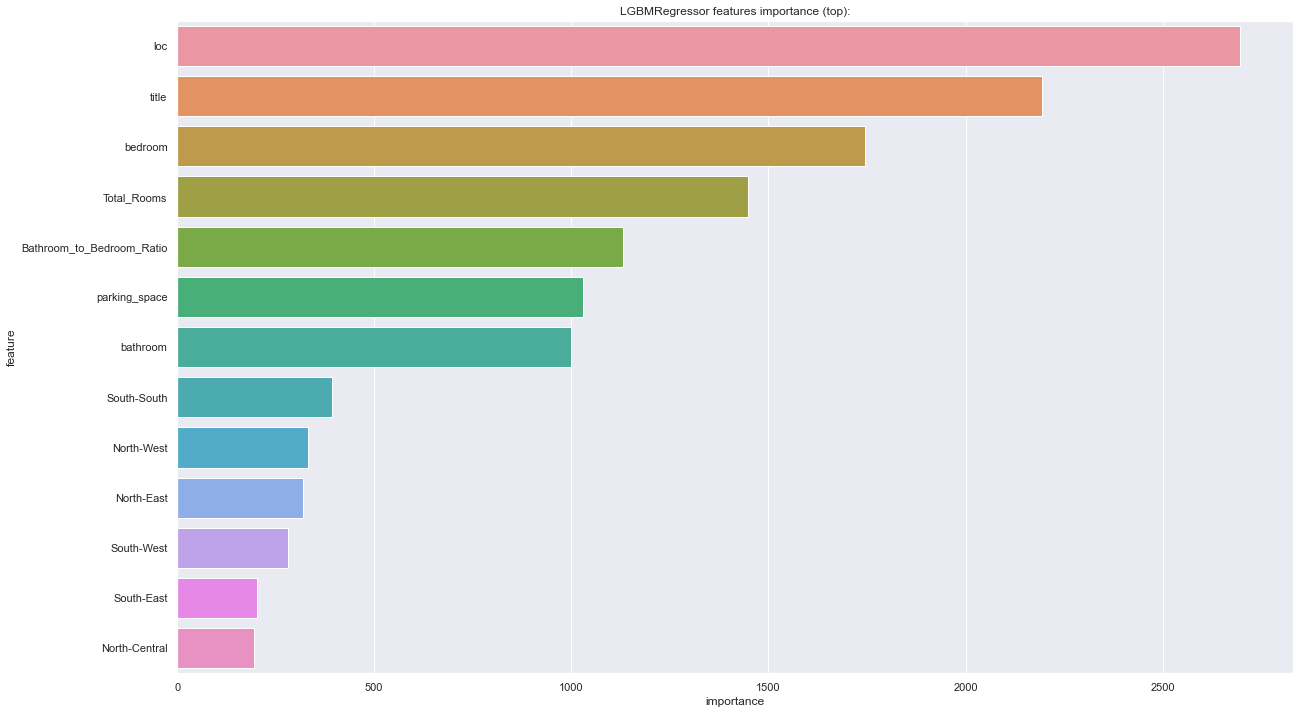

In [21]:
# # 0.7831404345536787
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('LGBMRegressor features importance (top):')